In [1]:
import pyfastchem as pyfc
import os
import petitRADTRANS.nat_cst as nc

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe


from tqdm import tqdm

In [2]:
class FastChemistry():

    def __init__(self, pressures):

        self.pressures = pressures

        pyfc_path = os.path.dirname(pyfc.__file__)
        self.element_file   = f'{pyfc_path}/input/element_abundances/asplund_2020_extended.dat'
        self.logK_gas_file  = f'{pyfc_path}/input/logK/logK_extended.dat'
        self.logK_cond_file = f'{pyfc_path}/input/logK/logK_condensates.dat'

        self.fastchem = pyfc.FastChem(
            self.element_file, self.logK_gas_file, self.logK_cond_file, 1
            )

        # Create in/out-put structures for FastChem
        self.input = pyfc.FastChemInput()
        self.input.pressure = self.pressures[::-1] # Flip to decrease

        self.output = pyfc.FastChemOutput()

        # Use equilibrium condensation
        self.input.equilibrium_condensation = True
        # Use rainout condensation approach
        self.input.rainout_condensation     = True
        #self.input.rainout_condensation     = False

        # Configure FastChem's internal parameters
        self.fastchem.setParameter('accuracyChem', 1e-6)
        self.fastchem.setParameter('accuracyElementConservation', 1e-6)
        #self.fastchem.setParameter('accuracyNewton', 1e-5)
        
        self.fastchem.setParameter('nbIterationsChem', 100000)
        #self.fastchem.setParameter('nbIterationsNewton', 10000)
        #self.fastchem.setParameter('nbIterationsNelderMead', 10000)

        # ------------------------------------------------------------------

        # Make a copy of the solar abundances from FastChem
        self.solar_abundances = np.array(self.fastchem.getElementAbundances())

        # Indices of carbon-bearing species
        self.index_C = np.array(self.fastchem.getElementIndex('C'))
        self.index_O = np.array(self.fastchem.getElementIndex('O'))

        # Compute the solar C/O ratio
        self.CO_solar = self.solar_abundances[self.index_C] / \
            self.solar_abundances[self.index_O]

        # Indices of H/He-bearing species
        index_H  = np.array(self.fastchem.getElementIndex('H'))
        index_He = np.array(self.fastchem.getElementIndex('He'))

        self.mask_metal = np.ones_like(self.solar_abundances, dtype=bool)
        self.mask_metal[index_H]  = False
        self.mask_metal[index_He] = False

    def get_VMR(self, species_i):
        index = self.fastchem.getGasSpeciesIndex(species_i)
        return self.VMR[:,index]
    
    def get_condensate_number_density(self, species_i):
        index = self.fastchem.getCondSpeciesIndex(species_i)
        return np.array(self.output.number_densities_cond)[::-1,index]
    
    def get_element_number_density(self, element_i):
        
        gas_indices = [self.fastchem.getGasSpeciesIndex(element_i)]
        cond_indices = []

        with open(self.logK_gas_file, 'r') as fp:
            for line in fp:
                if f' {element_i} ' in line:
                    species_i = line.split(' ')[0]
                    index_i   = self.fastchem.getGasSpeciesIndex(species_i)

                    gas_indices.append(index_i)

        with open(self.logK_cond_file, 'r') as fp:
            for line in fp:
                if f' {element_i} ' in line:
                    species_i = line.split(' ')[0]
                    index_i   = self.fastchem.getCondSpeciesIndex(species_i)

                    cond_indices.append(index_i)
                    
        gas_tot = np.sum(
            np.array(self.output.number_densities)[:,gas_indices], axis=1
        )
        cond_tot = np.sum(
            np.array(self.output.number_densities_cond)[:,cond_indices], axis=1
        )

        return gas_tot + cond_tot

    def __call__(self, T, CO, FeH):

        temperature = T * np.ones_like(self.pressures)
        if (temperature < 150).any():
            print('Replaced T<150 with T=150 K')
            temperature[temperature<150] = 150

        self.input.temperature = temperature[::-1] # Flip for FastChem usage

        # Make a copy to modify the elemental abundances
        element_abundances = self.solar_abundances.copy()
        metallicity_wrt_solar = 10**FeH

        # Apply C/O ratio and Fe/H to elemental abundances
        CO_correction = (1 + element_abundances[self.index_C]/element_abundances[self.index_O]) / (1+CO)

        element_abundances[self.index_C] = element_abundances[self.index_O] * CO
        
        element_abundances[self.index_C] *= CO_correction
        element_abundances[self.index_O] *= CO_correction

        element_abundances[self.mask_metal] *= metallicity_wrt_solar

        # Update the element abundances
        self.fastchem.setElementAbundances(element_abundances)

        # Compute the number densities
        fastchem_flag = self.fastchem.calcDensities(self.input, self.output)

        if fastchem_flag != 0:
            # FastChem failed to converge
            print('Failed to converge')
        if np.amin(self.output.element_conserved) != 1:
            # Failed element conservation
            print('Failed element conservation')

        # Compute the volume-mixing ratio of all species
        self.gas_number_density_tot = np.array(self.input.pressure)*1e6 / \
            (nc.kB * np.array(self.input.temperature))
        gas_number_density     = np.array(self.output.number_densities)

        self.VMR = gas_number_density / self.gas_number_density_tot[:,None]
        self.VMR = self.VMR[::-1] # Flip back

In [3]:
#T_eff = np.arange(700, 2400+1e-6, 100)
T_eff = np.arange(700, 2400+1e-6, 300)
#T_eff = np.array([700,1000])

VMR_tot = {'F': [], 'Fe': []}
VMR  = {'F1H1': [], 'Fe': [], 'Fe1H1': [], 'Mg': [], 'Al1F1': [], 'Na': [], 'K': []}
cond = {'Al2O3(s,l)': [], 'Al2SiO5(s)': [], 'KAlSi3O8(s)': [], 'NaAlSi3O8(s)': [], 'CH4(s,l)': []}
P = []
T = []

for FeH_i in [-0.5,0.0,0.5]:
#for FeH_i in [0.0]:
    for T_eff_i in tqdm(T_eff):

        # Read temperature profile
        path = '/home/sam/Documents/PhD/fastchem_tests/SONORA_ElfOwl_PT/' + \
            'spectra_logzz_7.0_teff_{:.1f}_grav_1000.0_mh_{:.1f}_co_1.0.dat'.format(T_eff_i, FeH_i)
            #'spectra_logzz_9.0_teff_{:.1f}_grav_1000.0_mh_0.0_co_1.0.dat'.format(T_eff_i)
        pressure, temperature = np.loadtxt(path).T

        # Compute the chemical equilibrium abundances
        FC = FastChemistry(pressures=pressure)
        #FC(T=temperature, CO=0.59, FeH=0.0)
        FC(T=temperature, CO=0.45, FeH=FeH_i)

        P.append(pressure)
        #T.append(temperature)
        T.append(FC.input.temperature[::-1])

        for hill_i in VMR.keys():
            VMR[hill_i].append(FC.get_VMR(hill_i))
            #VMR[hill_i].append(FC.get_VMR(hill_i)/FC.get_VMR('H2O1'))
        for hill_i in cond.keys():
            cond[hill_i].append(FC.get_condensate_number_density(hill_i))

        for element_i in VMR_tot.keys():
            VMR_tot_i = FC.get_element_number_density(element_i) \
                / FC.gas_number_density_tot
            VMR_tot[element_i].append(VMR_tot_i[::-1])
        

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:05<00:25,  5.08s/it]

Stoichiometry of species Tc1+ incomplete. Neglected!
Stoichiometry of species Tc1- incomplete. Neglected!
Stoichiometry of species Tc1++ incomplete. Neglected!

FastChem initialisation summary:
  number of species: 938    elements: 80    molecules: 672    condensates: 186

Stoichiometry of species Tc1+ incomplete. Neglected!


 33%|███▎      | 2/6 [00:09<00:18,  4.57s/it]

Stoichiometry of species Tc1- incomplete. Neglected!
Stoichiometry of species Tc1++ incomplete. Neglected!

FastChem initialisation summary:
  number of species: 938    elements: 80    molecules: 672    condensates: 186

Stoichiometry of species Tc1+ incomplete. Neglected!


 50%|█████     | 3/6 [00:15<00:15,  5.28s/it]

Stoichiometry of species Tc1- incomplete. Neglected!
Stoichiometry of species Tc1++ incomplete. Neglected!

FastChem initialisation summary:
  number of species: 938    elements: 80    molecules: 672    condensates: 186

Stoichiometry of species Tc1+ incomplete. Neglected!
Stoichiometry of species Tc1- incomplete. Neglected!
Stoichiometry of species Tc1++ incomplete. Neglected!


 67%|██████▋   | 4/6 [00:29<00:17,  8.94s/it]


FastChem initialisation summary:
  number of species: 938    elements: 80    molecules: 672    condensates: 186

Stoichiometry of species Tc1+ incomplete. Neglected!
Stoichiometry of species Tc1-

 83%|████████▎ | 5/6 [00:33<00:06,  6.99s/it]

 incomplete. Neglected!
Stoichiometry of species Tc1++ incomplete. Neglected!

FastChem initialisation summary:
  number of species: 938    elements: 80    molecules: 672    condensates: 186



100%|██████████| 6/6 [00:35<00:00,  5.91s/it]


Stoichiometry of species Tc1+ incomplete. Neglected!
Stoichiometry of species Tc1- incomplete. Neglected!
Stoichiometry of species Tc1++ incomplete. Neglected!

FastChem initialisation summary:
  number of species: 938    elements: 80    molecules: 672    condensates: 186



  0%|          | 0/6 [00:00<?, ?it/s]

Stoichiometry of species Tc1+ incomplete. Neglected!
Stoichiometry of species Tc1- incomplete. Neglected!
Stoichiometry of species Tc1++ incomplete. Neglected!

FastChem initialisation summary:
  number of species: 938    elements: 80    molecules: 672    condensates: 186



 17%|█▋        | 1/6 [00:07<00:36,  7.26s/it]

Stoichiometry of species Tc1+ incomplete. Neglected!
Stoichiometry of species Tc1- incomplete. Neglected!


 33%|███▎      | 2/6 [00:11<00:22,  5.62s/it]

Stoichiometry of species Tc1++ incomplete. Neglected!

FastChem initialisation summary:
  number of species: 938    elements: 80    molecules: 672    condensates: 186



 50%|█████     | 3/6 [00:17<00:17,  5.72s/it]

Stoichiometry of species Tc1+ incomplete. Neglected!
Stoichiometry of species Tc1- incomplete. Neglected!
Stoichiometry of species Tc1++ incomplete. Neglected!

FastChem initialisation summary:
  number of species: 938    elements: 80    molecules: 672    condensates: 186



 67%|██████▋   | 4/6 [00:27<00:14,  7.41s/it]

Stoichiometry of species Tc1+ incomplete. Neglected!
Stoichiometry of species Tc1- incomplete. Neglected!
Stoichiometry of species Tc1++ incomplete. Neglected!

FastChem initialisation summary:
  number of species: 938    elements: 80    molecules: 672    condensates: 186

Stoichiometry of species Tc1+ incomplete. Neglected!
Stoichiometry of species Tc1- incomplete. Neglected!
Stoichiometry of species Tc1++ incomplete. Neglected!

FastChem initialisation summary:
  number of species: 938    elements: 80    molecules: 672    condensates: 186



100%|██████████| 6/6 [00:45<00:00,  7.52s/it]


Stoichiometry of species Tc1+ incomplete. Neglected!
Stoichiometry of species Tc1- incomplete. Neglected!
Stoichiometry of species Tc1++ incomplete. Neglected!

FastChem initialisation summary:
  number of species: 938    elements: 80    molecules: 672    condensates: 186



 17%|█▋        | 1/6 [00:07<00:35,  7.06s/it]

Stoichiometry of species Tc1+ incomplete. Neglected!
Stoichiometry of species Tc1- incomplete. Neglected!
Stoichiometry of species Tc1++ incomplete. Neglected!

FastChem initialisation summary:
  number of species: 938    elements: 80    molecules: 672    condensates: 186



 33%|███▎      | 2/6 [00:13<00:26,  6.71s/it]

Stoichiometry of species Tc1+ incomplete. Neglected!
Stoichiometry of species Tc1- incomplete. Neglected!
Stoichiometry of species Tc1++ incomplete. Neglected!

FastChem initialisation summary:
  number of species: 938    elements: 80    molecules: 672    condensates: 186

Stoichiometry of species Tc1+ incomplete. Neglected!
Stoichiometry of species Tc1- incomplete. Neglected!


 50%|█████     | 3/6 [00:18<00:18,  6.10s/it]

Stoichiometry of species Tc1++ incomplete. Neglected!

FastChem initialisation summary:
  number of species: 938    elements: 80    molecules: 672    condensates: 186



 67%|██████▋   | 4/6 [00:27<00:14,  7.04s/it]

Stoichiometry of species Tc1+ incomplete. Neglected!
Stoichiometry of species Tc1- incomplete. Neglected!
Stoichiometry of species Tc1++ incomplete. Neglected!

FastChem initialisation summary:
  number of species: 938    elements: 80    molecules: 672    condensates: 186

Stoichiometry of species Tc1+ incomplete. Neglected!
Stoichiometry of species Tc1- incomplete. Neglected!
Stoichiometry of species Tc1++ incomplete. Neglected!

FastChem initialisation summary:
  number of species: 938    elements: 80    molecules: 672    condensates: 186



100%|██████████| 6/6 [00:41<00:00,  6.98s/it]

Stoichiometry of species Tc1+ incomplete. Neglected!
Stoichiometry of species Tc1- incomplete. Neglected!
Stoichiometry of species Tc1++ incomplete. Neglected!

FastChem initialisation summary:
  number of species: 938    elements: 80    molecules: 672    condensates: 186



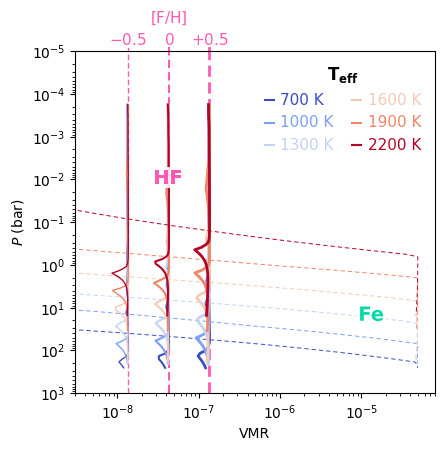

In [114]:
color_species = {'HF':'#FF59B4', '12CO':'C2', 'H2O':'C3', 'NH3':'C8', 'CH4':'C4', 'H2S':'C1', 'FeH':'#00DBA8', 'Na':'C1'}
cmap = plt.get_cmap('coolwarm')
N = len(T_eff)

fig = plt.figure(figsize=(4.5,4.5))
#fig = plt.figure(figsize=(4,4))
gs = fig.add_gridspec(
    nrows=1, ncols=1, hspace=0.2, wspace=0.08, 
)
ax = np.array([fig.add_subplot(gs[0,0])])

for i, T_eff_i in enumerate(T_eff):
    c = cmap((T_eff_i-T_eff.min())/(T_eff.max()-T_eff.min()))

    ax[0].plot(VMR['F1H1'][i], P[i], c=c, lw=1)
    ax[0].plot(VMR['F1H1'][i+N], P[i+N], c=c, label='{:.0f} K'.format(T_eff_i), lw=1.5)
    ax[0].plot(VMR['F1H1'][i+2*N], P[i+2*N], c=c, lw=2)

    #ax[0].plot(VMR['Fe1H1'][i+N], P[i+N], c=c, lw=1, ls=':')
    ax[0].plot(VMR['Fe'][i+N], P[i+N], c=c, lw=0.7, ls=(0,(4.5,3)))
    
    #ax[0].plot(VMR['Na'][i+N], P[i+N], c=c, lw=0.7, ls=(0,(4.5,3)))
    #ax[0].plot(VMR['K'][i+N], P[i+N], c=c, lw=1, ls='-.')
    #ax[0].plot(VMR['Mg'][i+N], P[i+N], c=c, lw=1, ls=':')
    
    #ax[0].plot(VMR['Al1F1'][i+N], P[i+N], c=c, ls=':')

'''
color_A = '#FF622E'; color_B = '#396ED8'
for VMR_posterior_i, P_i, color_i in zip([VMR_posterior_A, VMR_posterior_B], [1,1.4], [color_A, color_B]):
    x = np.median(VMR_posterior_i['HF'][:,0])
    #xerr = np.quantile(VMR_posterior_i['HF'][:,0], q=q[[2,4]]) - x
    xerr = np.quantile(VMR_posterior_i['HF'][:,0], q=q[[0,-1]]) - x
    xerr = np.abs(xerr)[:,None]
    ax[0].errorbar(x=x, y=P_i, xerr=xerr, fmt='.', c=color_i, markersize=6, lw=1.5, capthick=1.5, capsize=2)
'''

ann_kwargs = dict(
    xycoords=ax[0].get_xaxis_transform(), 
    ha='center', va='bottom', c=color_species['HF'], 
    fontsize=11, fontweight='bold', 
)

xticks = []
for VMR_i, label_i, lw_i in zip(np.array(VMR_tot['F'])[[0,N,2*N],-1], [r'$-0.5$',''r'$0$',r'$+0.5$'], [1,1.5,2]):
    ax[0].axvline(VMR_i, c=color_species['HF'], lw=lw_i, ls=(0,(4,2)), zorder=-1)
    ax[0].axvline(VMR_i, ymin=1, ymax=1.01, clip_on=False, c=color_species['HF'], lw=lw_i, zorder=-1)
    ax[0].annotate(label_i, xy=(VMR_i, 1.01), **ann_kwargs)
ax[0].annotate(r'$\mathrm{[F/H]}$', xy=(VMR_tot['F'][N][-1], 1.07), **ann_kwargs)

#ax[0].axvline(VMR_tot['Fe'][N][-1], c=color_species['FeH'], lw=1, ls=(0,(4,2)), zorder=-1)

ann_kwargs['fontsize'] = 14
ann_kwargs['path_effects'] = [pe.withStroke(linewidth=5, foreground='w', alpha=0.9)]
ax[0].annotate('HF', xy=(VMR['F1H1'][N][0], 0.6), clip_on=True, **ann_kwargs)

ann_kwargs['c'] = color_species['FeH']
ax[0].annotate('Fe', xy=(VMR['Fe'][N][-5], 0.2), clip_on=True, **ann_kwargs)

#ann_kwargs['c'] = color_species['Na']
#ax[0].annotate('Na', xy=(VMR['Na'][N][69], 0.5), clip_on=True, **ann_kwargs)

ax[0].legend(
    loc='upper right', bbox_to_anchor=(1,1), ncols=2, edgecolor='none', 
    columnspacing=1.2, handlelength=0.6, handletextpad=0.4, handleheight=0.3, 
    labelcolor='linecolor', prop={'size':11}, 
    title=r'${\bf T_{eff}}$', title_fontsize=12,
)
ax[0].set(
    xscale='log', yscale='log', ylim=(1e3,1e-5), xlim=(3e-9,8e-5), 
    #xlim=(5e-9,3e-6), 
    xlabel='VMR', ylabel=r'$P\ (\mathrm{bar})$'
)

plt.subplots_adjust(left=0.17, bottom=0.12, top=0.88, right=0.97)
plt.savefig('./plots/HF_VMR.pdf')
plt.show()

In [62]:
contr_A = np.load(f'{Res_A.prefix}data/bestfit_int_contr_em_{Res_A.m_set}.npy')
contr_B = np.load(f'{Res_B.prefix}data/bestfit_int_contr_em_{Res_B.m_set}.npy')

In [67]:
np.argmax(contr_A), np.argmax(contr_B)

(33, 33)

In [26]:
import utils

Res_A = utils.RetrievalResults(
    prefix='../retrieval_outputs/new_fiducial_K_A_ret_9/test_', 
    m_set='K2166_A', w_set='K2166', load_posterior=True
    )
Res_B = utils.RetrievalResults(
    prefix='../retrieval_outputs/new_fiducial_K_B_ret_6/test_', 
    m_set='K2166_B', w_set='K2166', load_posterior=True
    )

  analysing data from ../retrieval_outputs/new_fiducial_K_A_ret_9/test_.txt
['modes', 'nested sampling global log-evidence', 'nested sampling global log-evidence error', 'global evidence', 'global evidence error', 'nested importance sampling global log-evidence', 'nested importance sampling global log-evidence error', 'marginals']
999299.4634225854
999271.5748447548
999271.5748447548
  analysing data from ../retrieval_outputs/new_fiducial_K_B_ret_6/test_.txt
['modes', 'nested sampling global log-evidence', 'nested sampling global log-evidence error', 'global evidence', 'global evidence error', 'nested importance sampling global log-evidence', 'nested importance sampling global log-evidence error', 'marginals']
1008102.5003663264
1008080.2585288256
1008080.2585288256


In [27]:
Chem_A = Res_A._load_object('Chem')
VMR_posterior_A = utils.convert_mf_dict_to_VMR_dict(Chem_A, relative_to_key=None)

Chem_B = Res_B._load_object('Chem')
VMR_posterior_B = utils.convert_mf_dict_to_VMR_dict(Chem_B, relative_to_key=None)

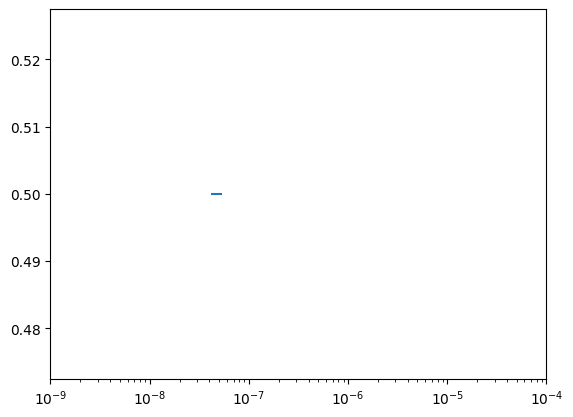

In [22]:
q = np.array([
    0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 
    0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2
    ])

x = np.median(VMR_posterior_A['HF'][:,0])
#xerr = np.quantile(VMR_posterior_A['HF'][:,0], q=q[[2,4]]) - x
xerr = np.quantile(VMR_posterior_A['HF'][:,0], q=q[[0,-1]]) - x
xerr = np.abs(xerr)[:,None]

plt.errorbar(x=x, y=0.5, xerr=xerr, fmt='')
plt.xlim(1e-9,1e-4)
plt.xscale('log')
plt.show()